In [1]:
import numpy as np
from PIL import Image
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
def Lp(x,y,im): #returns -L!!! +L makes result all black
    L=((im[x-1,y]  if x-1>=0 else 0 )+(im[x+1,y]  if x+1<im.shape[0] else 0)+(im[x,y-1]  if y-1>=0 else 0)+(im[x,y+1]  if y+1<im.shape[1] else 0)-4*im[x,y])
    return L

def deLp(x,y,im):
    deL=((Lp(x+1,y,im)  if x+1<im.shape[0] else 0) - (Lp(x-1,y,im)  if x-1>=0 else 0), (Lp(x,y+1,im)  if y+1<im.shape[1] else 0) - (Lp(x,y-1,im)  if y-1>=0 else 0))
    return deL

def normN_test(x,y,im):
    Ix=((im[x+1,y]  if x+1<im.shape[0] else 0)-(im[x-1,y]  if x-1>=0 else 0 ))/2;
    Iy=((im[x,y+1]  if y+1<im.shape[1] else 0)-(im[x,y-1]  if y-1>=0 else 0))/2;
    
    magI=np.sqrt((Ix*Ix)+(Iy*Iy))
    
    if(magI==0):
        Nnorm=(0,0)
    else:
        Nnorm=(-Iy/magI,Ix/magI)
    
    return Nnorm,Ix,Iy


def normN(x,y,im):
    Ix=((im[x+1,y]  if x+1<im.shape[0] else 0)-(im[x-1,y]  if x-1>=0 else 0 ))/2;
    Iy=((im[x,y+1]  if y+1<im.shape[1] else 0)-(im[x,y-1]  if y-1>=0 else 0))/2;
    
    magI=np.sqrt((Ix*Ix)+(Iy*Iy))
    
    if(magI==0):
        Nnorm=(0,0)
    else:
        Nnorm=(-Iy/magI,Ix/magI)
    
    return Nnorm

# if mask values are 0??
#taking f slope for increasing L and b slope for decreasing L
#say propogating 1D sigmoid(-x) over x>0 if we take forward slope we consider that function is dropping at boundary and propogate that perception but we want the propogation to reflect the prev state (before boundary)

def slGrad(x,y,im,B):
    Ixf=(im[x+1,y]  if x+1<im.shape[0] else 0)-im[x,y]
    Ixb=im[x,y]-(im[x-1,y]  if x-1>=0 else 0)
    Iyf=(im[x,y+1]  if y+1<im.shape[1] else 0)-im[x,y]
    Iyb=im[x,y]-(im[x,y-1]  if y-1>=0 else 0)
    
    Ixfm=np.minimum(Ixf,0)
    IxfM=np.maximum(Ixf,0)
    Ixbm=np.minimum(Ixb,0)
    IxbM=np.maximum(Ixb,0)
    Iyfm=np.minimum(Iyf,0)
    IyfM=np.maximum(Iyf,0)
    Iybm=np.minimum(Iyb,0)
    IybM=np.maximum(Iyb,0)
    
    if(B>0):
        sl_Grad=np.sqrt((Ixbm*Ixbm)+(IxfM*IxfM)+(Iybm*Iybm)+(IyfM*IyfM))
    else:
        sl_Grad=np.sqrt((IxbM*IxbM)+(Ixfm*Ixfm)+(IybM*IybM)+(Iyfm*Iyfm))
        
    return sl_Grad


def slGrad_test(x,y,im,B):
    Ixf=(im[x+1,y]  if x+1<im.shape[0] else 0)-im[x,y]
    Ixb=im[x,y]-(im[x-1,y]  if x-1>=0 else 0)
    Iyf=(im[x,y+1]  if y+1<im.shape[1] else 0)-im[x,y]
    Iyb=im[x,y]-(im[x,y-1]  if y-1>=0 else 0)
    
    Ixfm=np.minimum(Ixf,0) #WTF?!?!?!?!?!?!?!!??!?!
    IxfM=np.maximum(Ixf,0)
    Ixbm=np.minimum(Ixb,0)
    IxbM=np.maximum(Ixb,0)
    Iyfm=np.minimum(Iyf,0)
    IyfM=np.maximum(Iyf,0)
    Iybm=np.minimum(Iyb,0)
    IybM=np.maximum(Iyb,0)
    
    if(B>0):
        sl_Grad=np.sqrt((Ixbm*Ixbm)+(IxfM*IxfM)+(Iybm*Iybm)+(IyfM*IyfM))
    else:
        sl_Grad=np.sqrt((IxbM*IxbM)+(Ixfm*Ixfm)+(IybM*IybM)+(Iyfm*Iyfm))
        
    print("Ixf: ",Ixf)
    print("Ixb: ",Ixb)
    print("Iyf: ",Iyf)
    print("Iyb: ",Iyb)
    
    print("Ixfm: ",Ixfm)
    print("IxfM: ",IxfM)
    print("Ixbm: ",Ixbm)
    print("IxbM: ",IxbM)
    print("Iyfm: ",Iyfm)
    print("IyfM: ",IyfM)
    print("Iybm: ",Iybm)
    print("IybM: ",IybM)
        
    return sl_Grad


In [3]:
#sigmoid across x (21x21) mask 9 b 5

sigxim=np.zeros((21,21)) #0-20
sigximms=np.zeros((sigxim.shape[0],sigxim.shape[1])) #0-20

bs=5
ms=9

for ri in range(0,sigxim.shape[0]):
    for ci in range(0,sigxim.shape[1]):
        if(ci>=(sigxim.shape[0]-1)/2-(bs-1)/2 and ci<=(sigxim.shape[0]-1)/2+(bs-1)/2):
            sigxim[ri,ci]=0
        else:
            sigxim[ri,ci]=1/(1+np.exp(-1*(ri-(sigxim.shape[0]-1)/2)))*255
        
for ri in range(0,sigximms.shape[0]):
    for ci in range(0,sigximms.shape[1]):
        if(ci>=(sigximms.shape[0]-1)/2-(ms-1)/2 and ci<=(sigximms.shape[0]-1)/2+(ms-1)/2):
            sigximms[ri,ci]=255
        else:
            sigximms[ri,ci]=0

In [4]:
print(type(sigxim[0][0]))

<class 'numpy.float64'>


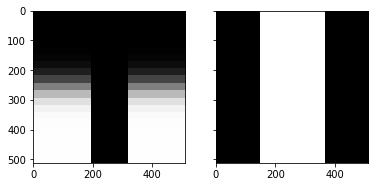

In [5]:

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(Image.fromarray(np.uint8(sigxim)).resize((512,512)))
ax2.imshow(Image.fromarray(np.uint8(sigximms)).resize((512,512)))

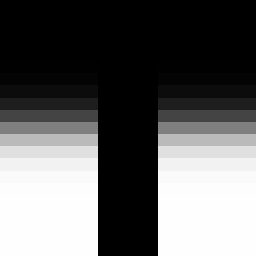

In [6]:
display(Image.fromarray(np.uint8(sigxim)).resize((256,256)))


In [7]:
Lsig=np.zeros((sigxim.shape[0],sigxim.shape[1]))
deLsig=np.zeros((sigxim.shape[0],sigxim.shape[1],2))
normsig=np.zeros((sigxim.shape[0],sigxim.shape[1],2))

for ri in range(0,sigxim.shape[0]):
    for ci in range(0,sigximms.shape[1]):
        Lsig[ri,ci]=Lp(ri,ci,sigxim)

for ri in range(0,sigxim.shape[0]):
    for ci in range(0,sigxim.shape[1]):
        deLsig[ri,ci]=deLp(ri,ci,sigxim)
        normsig[ri,ci]=normN(ri,ci,sigxim)
# print(Lsig)

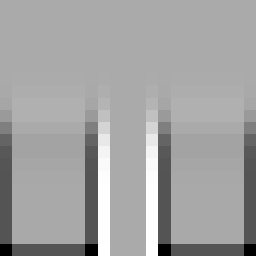

In [8]:
display(Image.fromarray(np.uint8(((Lsig-np.min(Lsig))/(np.max(Lsig)-np.min(Lsig)))*255)).resize((256,256)))

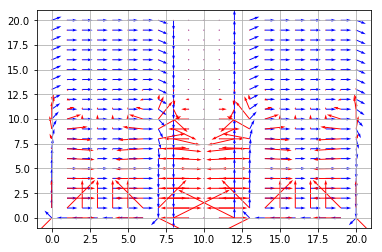

In [9]:
plt.quiver(range(0,sigximms.shape[1]), range(0,sigximms.shape[0]), np.flipud(normsig[:,:,1]), np.flipud(-1*normsig[:,:,0]),color='blue')
plt.quiver(range(0,sigximms.shape[1]), range(0,sigximms.shape[0]), np.flipud(deLsig[:,:,1]), np.flipud(-1*deLsig[:,:,0]),color='red')

plt.grid()
plt.show()

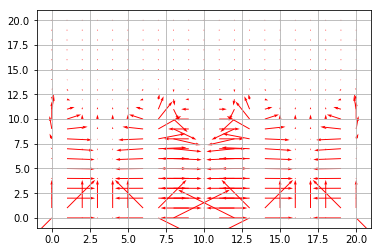

In [10]:
plt.quiver(range(0,sigximms.shape[1]), range(0,sigximms.shape[0]), np.flipud(deLsig[:,:,1]), np.flipud(-1*deLsig[:,:,0]),color='red')

plt.grid()
plt.show()

In [11]:
itrs=1
eta=1*10**(-5) #eta is iffy

start=time.time() #139.5
cim=sigxim.astype('float') #imp!!!!
imt=np.zeros((cim.shape[0],cim.shape[1]))
rim=np.zeros((cim.shape[0],cim.shape[1]))


for it in range(0,itrs):
    print(it)
    for ri in range(0,cim.shape[0]):
        for ci in range(0,cim.shape[1]):
            if(sigximms[ri,ci]==255):
                B=np.dot(deLp(ri,ci,cim),normN(ri,ci,cim))
                imt[ri,ci]=B*slGrad(ri,ci,cim,B)
                rim[ri,ci]=cim[ri,ci]+eta*imt[ri,ci]
            else:
                rim[ri,ci]=cim[ri,ci]
    cim=np.clip(rim, 0, 255) #imp!!!
    

end=time.time()
print(end-start) 

0
0.007677793502807617


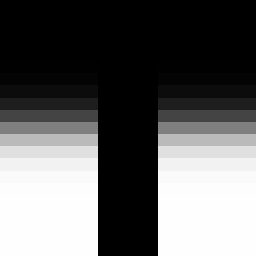

In [12]:
display(Image.fromarray(np.uint8(cim)).resize((256,256)))

In [13]:
cim=sigxim.astype('float')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144


3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807


5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462


6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173


8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961


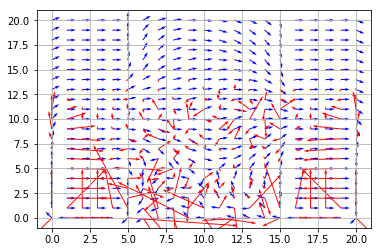

In [14]:
itrs=10000
eta=0.001#1*10**(-6) #eta is iffy

imt=np.zeros((cim.shape[0],cim.shape[1]))
rim=np.zeros((cim.shape[0],cim.shape[1]))


for it in range(0,itrs):
    print(it)
    for ri in range(0,cim.shape[0]):
        for ci in range(0,cim.shape[1]):
            if(sigximms[ri,ci]==255):
                B=np.dot(deLp(ri,ci,cim),normN(ri,ci,cim))
                imt[ri,ci]=B*slGrad(ri,ci,cim,B)
                rim[ri,ci]=cim[ri,ci]+eta*imt[ri,ci]
            else:
                rim[ri,ci]=cim[ri,ci]
    cim=np.clip(rim, 0, 255) #imp!!!
    
tLsig=np.zeros((sigxim.shape[0],sigxim.shape[1]))
tdeLsig=np.zeros((sigxim.shape[0],sigxim.shape[1],2))
tnormsig=np.zeros((sigxim.shape[0],sigxim.shape[1],2))
tnormtsig=np.zeros((sigxim.shape[0],sigxim.shape[1],2))

for ri in range(0,sigxim.shape[0]):
    for ci in range(0,sigxim.shape[1]):
        tLsig[ri,ci]=Lp(ri,ci,cim)

for ri in range(0,sigxim.shape[0]):
    for ci in range(0,sigxim.shape[1]):
        tdeLsig[ri,ci]=deLp(ri,ci,cim)
        tnormsig[ri,ci]=normN(ri,ci,cim)

plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(tnormsig[:,:,1]), np.flipud(-1*tnormsig[:,:,0]),color='blue')
plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(tdeLsig[:,:,1]), np.flipud(-1*tdeLsig[:,:,0]),color='red')

plt.grid()
plt.show()

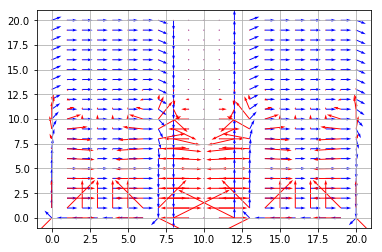

In [15]:
plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(normsig[:,:,1]), np.flipud(-1*normsig[:,:,0]),color='blue')
plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(deLsig[:,:,1]), np.flipud(-1*deLsig[:,:,0]),color='red')

plt.grid()
plt.show()

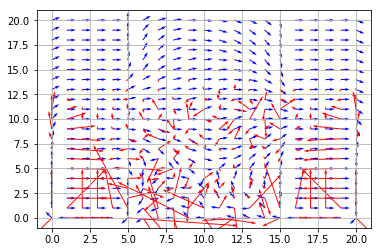

In [16]:
for ri in range(0,sigxim.shape[0]):
    for ci in range(0,sigxim.shape[1]):
        tLsig[ri,ci]=Lp(ri,ci,cim)

for ri in range(0,sigxim.shape[0]):
    for ci in range(0,sigxim.shape[1]):
        tdeLsig[ri,ci]=deLp(ri,ci,cim)
        tnormsig[ri,ci]=normN(ri,ci,cim)

plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(tnormsig[:,:,1]), np.flipud(-1*tnormsig[:,:,0]),color='blue')
plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(tdeLsig[:,:,1]), np.flipud(-1*tdeLsig[:,:,0]),color='red')

plt.grid()
plt.show()

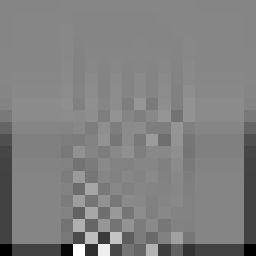

In [17]:
display(Image.fromarray(np.uint8(((tLsig-np.min(tLsig))/(np.max(tLsig)-np.min(tLsig)))*255)).resize((256,256)))

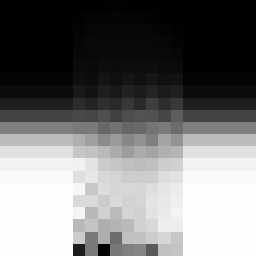

In [18]:
display(Image.fromarray(np.uint8(cim)).resize((256,256)))

In [19]:
ii=[8,8]

In [20]:
print(tdeLsig[ii[0],ii[1],:])

[-19.0276532  -12.50679389]


In [21]:
print(tnormsig[ii[0],ii[1],:])

[-0.12062655  0.99269796]


In [22]:
rtz=4

In [23]:
tB=np.dot(tdeLsig[ii[0],ii[1],:],tnormsig[ii[0],ii[1],:])
print(tB)

-10.120228499280103


In [24]:
tslGrad=slGrad_test(8,8,cim,tB)
print(tslGrad)
#np.sqrt((IxbM*IxbM)+(Ixfm*Ixfm)+(IybM*IybM)+(Iyfm*Iyfm))

Ixf:  31.368323433244427
Ixb:  17.498883878996363
Iyf:  -5.061551098760589
Iyb:  10.999593796500257
Ixfm:  0.0
IxfM:  31.368323433244427
Ixbm:  0.0
IxbM:  17.498883878996363
Iyfm:  -5.061551098760589
IyfM:  0.0
Iybm:  0.0
IybM:  10.999593796500257
21.27959821575516


In [25]:
print(np.sqrt(140.48657536785782*140.48657536785782+-171.7004672676909*-171.7004672676909+-171.7004672676909*-171.7004672676909))

280.53266971687196


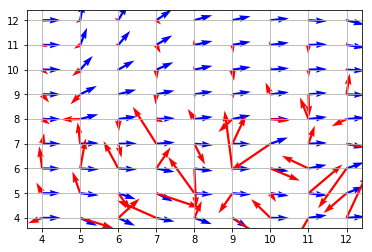

In [26]:
plt.quiver(range(ii[0]-rtz,ii[0]+rtz+1), range(ii[1]-rtz,ii[1]+rtz+1), np.flipud(tnormsig[ii[0]-rtz:ii[0]+rtz+1,ii[1]-rtz:ii[1]+rtz+1,1]), np.flipud(-1*tnormsig[ii[0]-rtz:ii[0]+rtz+1,ii[1]-rtz:ii[1]+rtz+1,0]),color='blue')
plt.quiver(range(ii[0]-rtz,ii[0]+rtz+1), range(ii[1]-rtz,ii[1]+rtz+1), np.flipud(tdeLsig[ii[0]-rtz:ii[0]+rtz+1,ii[1]-rtz:ii[1]+rtz+1,1]), np.flipud(-1*tdeLsig[ii[0]-rtz:ii[0]+rtz+1,ii[1]-rtz:ii[1]+rtz+1,0]),color='red')

plt.grid()
plt.show()

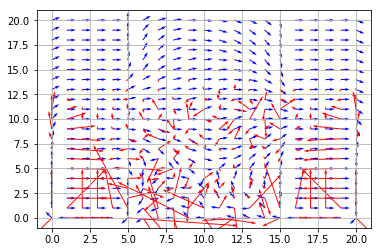

In [27]:
plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(tnormsig[:,:,1]), np.flipud(-1*tnormsig[:,:,0]),color='blue')
plt.quiver(range(0,sigxim.shape[1]), range(0,sigxim.shape[0]), np.flipud(tdeLsig[:,:,1]), np.flipud(-1*tdeLsig[:,:,0]),color='red')

plt.grid()
plt.show()

In [28]:
print(np.minimum(5,7))

5
